# Experiment mit dem Datensatz "Global Mean Sea level"

In [1]:
using Distributions, Compat, Plots, Random, CSV, DataFrames, GLM, Printf, LaTeXStrings
upscale = 1.1
Plots.scalefontsizes(1.5)
default(line = (:line, 0.5, 1, 2), size=(800*upscale,600*upscale))
default(dpi = 100)
# default(dpi = 300)

┌ Info: Recompiling stale cache file /home/meszlenyilorant/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/meszlenyilorant/.julia/compiled/v1.0/GLM/6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1190


In [2]:
function write_tex(text::String, name)
    open("./" * name * ".tex", "w") do f
        write(f, text)
    end
end

function format_data(data) 
    @sprintf "%12.2f" data
end

format_data (generic function with 1 method)

In diesem Abschnitt wird das Kalman Filter auf realen Daten angewendet. Dazu wird die Entwicklung der Meeresspiegel für Monaten genutzt. Die Daten stammen von [hier](https://datahub.io/core/sea-level-rise).

Wir lesen die Datei ein, entfernen fehlende Werte und erhalten:

In [3]:
data = CSV.File("./co2-level.csv") |> DataFrame # Read csv and create a dataframe
data[:Mean] = convert(Array{Float64, 1}, data[:Mean]) # Convert col to number
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Union…,DataType
1,Year,1988.0,1959,1988.0,2017,,0,Int64
2,Mean,353.481,315.97,351.57,406.55,,,Float64
3,Uncertainty,0.12,0.12,0.12,0.12,,0,Float64


Die Spalten sind wie folgt:

- Year: Jahr der Erfassung 
- Mean: CO2 wert
- Uncertainity: Gibt an, wie sicher die Messung aus der Spalte `Mean` ist.

In [5]:
first(data, 6)

,Year,Mean,Uncertainty
,Int64⍰,Float64,Float64⍰
1,1959,315.97,0.12
2,1960,316.91,0.12
3,1961,317.64,0.12
4,1962,318.45,0.12
5,1963,318.99,0.12
6,1964,319.62,0.12


Die Entwicklung der Meeresspiegel ist folgendes:

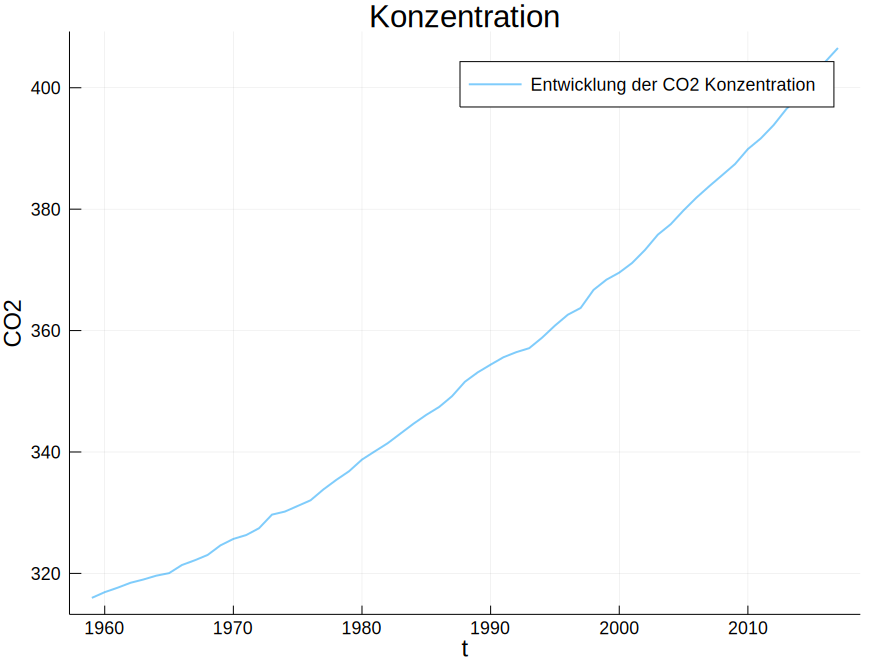

In [7]:
plot_co = plot(data[:Year], data[:Mean], 
    label = "Entwicklung der CO2 Konzentration", 
    xlabel = "t", 
    ylabel = "CO2",
    title = "Konzentration",
)
png("co2.png")
plot_co

In [11]:
linearmodel = fit(LinearModel, @formula(Mean ~ Year), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Mean ~ 1 + Year

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  -2731.42   51.1678 -53.3817   <1e-49
Year          1.55176 0.0257374  60.2922   <1e-52


In [12]:
@show coef(linearmodel)
@show stderror(linearmodel)
error = stderror(linearmodel)[1];

coef(linearmodel) = [-2731.42, 1.55176]
stderror(linearmodel) = [51.1678, 0.0257374]


In [13]:
table(e1, e2, e3) =
"""
    \\begin{tabular}{l|l|l|l|l}\n
               & E         & Std      & \\(\\sum\\) Innovation & \\(\\sum\\) \\(x(k|k-1)-x(k|k)\\) \\\\
    \\hhline{=|=|=|=|=}

    Ergebnisse &           &          &            & \\\\
    1.         & $(e1[1])  & $(e1[2]) & $(e1[4])   & $(e1[5]) \\\\
    2.         & $(e2[1])  & $(e2[2]) & $(e2[4])   & $(e2[5]) \\\\
    3.         & $(e3[1])  & $(e3[2]) & $(e3[4])   & $(e3[5]) \\\\
    \\hline
    Original   & $(mean(data.GMSL) |> format_data) & $(std(data.GMSL) |> format_data) &  & \\\\
    \\end{tabular}
"""
results = []

0-element Array{Any,1}

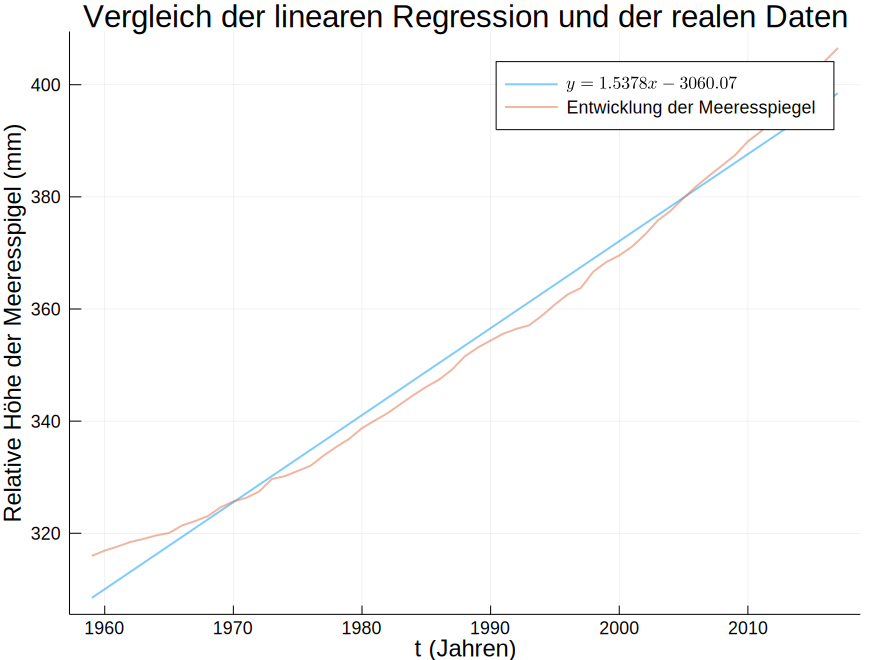

In [15]:
f(x) = coef(linearmodel)[2] * x + coef(linearmodel)[1]
plot_linear_regression = plot(xlabel = "t (Jahren)", ylabel = "Relative Höhe der Meeresspigel (mm)", title = "Vergleich der linearen Regression und der realen Daten")
plot!(data[:Year], f.(data[:Year]), label = L"y = 1.5378x - 3060.07")
plot!(data[:Year], data[:Mean], label = "Entwicklung der Meeresspiegel")
png("linear_regression.png")
plot_linear_regression

In [25]:
include("../KalmanFilter.jl")
import .KalmanFilter

In [17]:
function shift(r)
   range(first(r) + 1, min(last(r) + 1, size(data)[1]))
end

shift (generic function with 1 method)

In [39]:
function experiment(A, Q, G, R)

    # A = 1 # Zustandsübergangsmatrix
    # Q = 0.001

    # G = 1 # Messabbildung Matrix
    # R = 0.6

    x̂_0 = data[1, :Mean]
    # x̂_0 = f(1)
    Σ_0 = 1000

    model = KalmanFilter.Kalman(A, Q, G, R, x̂_0, Σ_0)

    data[:Fusioned] = map(x -> 0.0, data[:Year])
    data[:Predicted] = map(x -> 0.0, data[:Year])
    data[:Gain] = map(x -> 0.0, data[:Year])
    data[:Moving_Avg] = map(x -> 0.0, data[:Year])

    prev_prediction = -180

    current_window = 1:3
    for row in eachrow(data)
        y_cur = row[:Mean]
        newInstance = KalmanFilter.next(model, y_cur)
        row[:Fusioned] = newInstance.fusioned
        row[:Predicted] = prev_prediction
        row[:Gain] = newInstance.gain
        row[:Moving_Avg] = mean(data[current_window, :Mean])

        current_window = shift(current_window)
        prev_prediction = newInstance.predicted
        model = newInstance.model
    end
    push!(results, (mean(data.Fusioned) |> format_data, 
            std(data.Fusioned) |> format_data, 
            var(data.Fusioned) |> format_data, 
            sum(abs.(data.Fusioned - data.Mean)) |> format_data, 
            sum(abs.(data.Predicted - data.Fusioned)) |> format_data)
    )
    
    plot_kalman = plot(
        legend = :bottomright,
        xlabel = "t (Jahren)", 
        ylabel = "Meeresspigel (mm)",
        title = "Anwendung des Kalman Filter auf das Datensatz mit Parameter A = $A, Q = $Q, G = $G, R = $R")
    plot!(data[:Year], data[:Mean], label = "GMSL", smooth = true)
    plot!(data[:Year], data[:Fusioned], label = "Korrektur", smooth = true)
    plot!(data[:Year], data[:Moving_Avg], label = "Gleitender Mittelwert")
#     plot!(Shape([1900, 1900, 1920, 1920], [-140, -80, -80, -140]), opacity = 0, label = "")
end

experiment (generic function with 1 method)

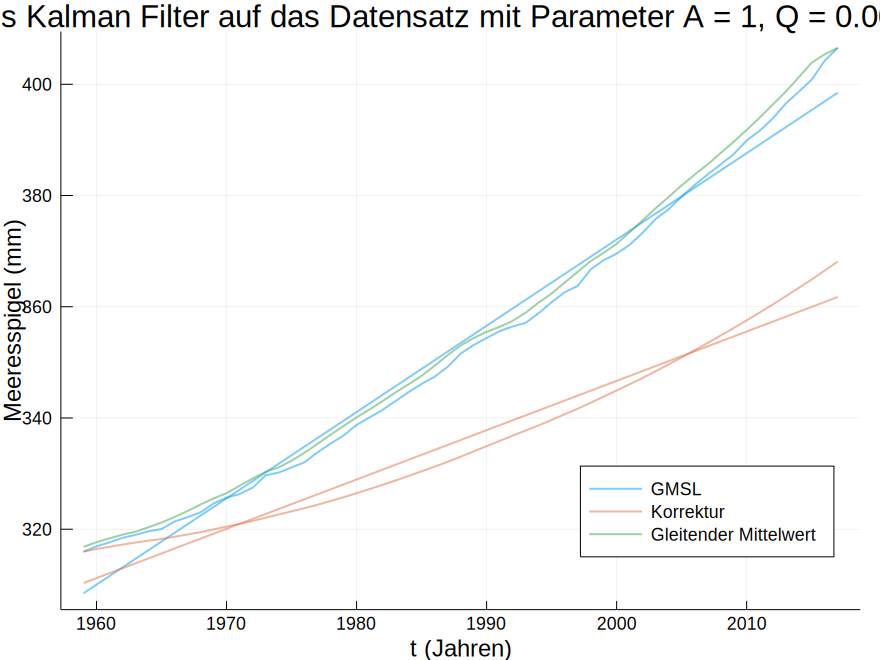

In [40]:
experiment(1, 0.001, 1, 0.6)

In [42]:
fit(LinearModel, @formula(Fusioned ~ Year), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Fusioned ~ 1 + Year

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  -1426.83   43.4812 -32.8149   <1e-37
Year         0.886756  0.021871  40.5448   <1e-43


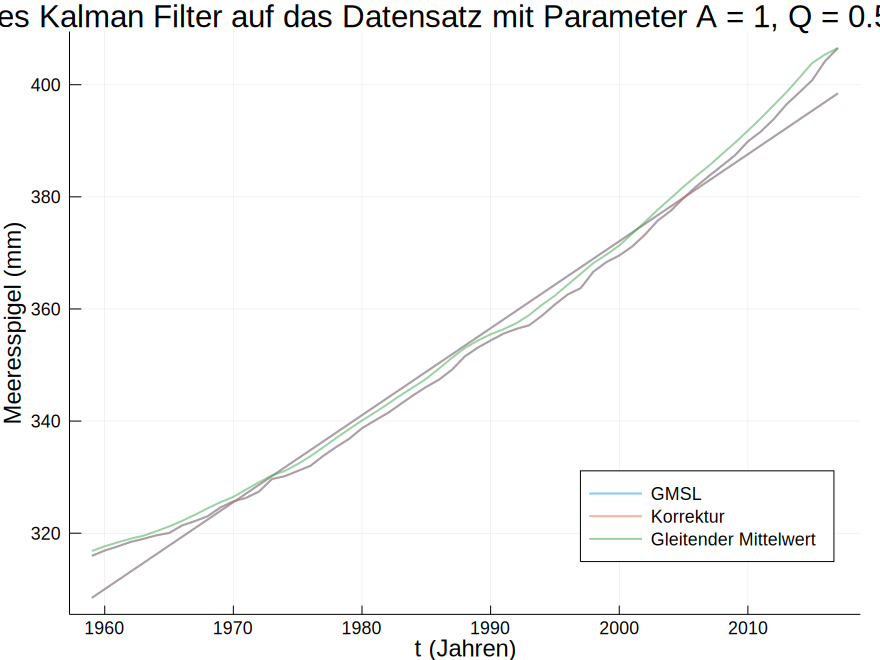

In [43]:
experiment(1, 0.5, 1, 0.01)

In [44]:
fit(LinearModel, @formula(Fusioned ~ Year), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Fusioned ~ 1 + Year

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)   -2730.3   51.1602 -53.3677   <1e-49
Year          1.55118 0.0257336  60.2786   <1e-52


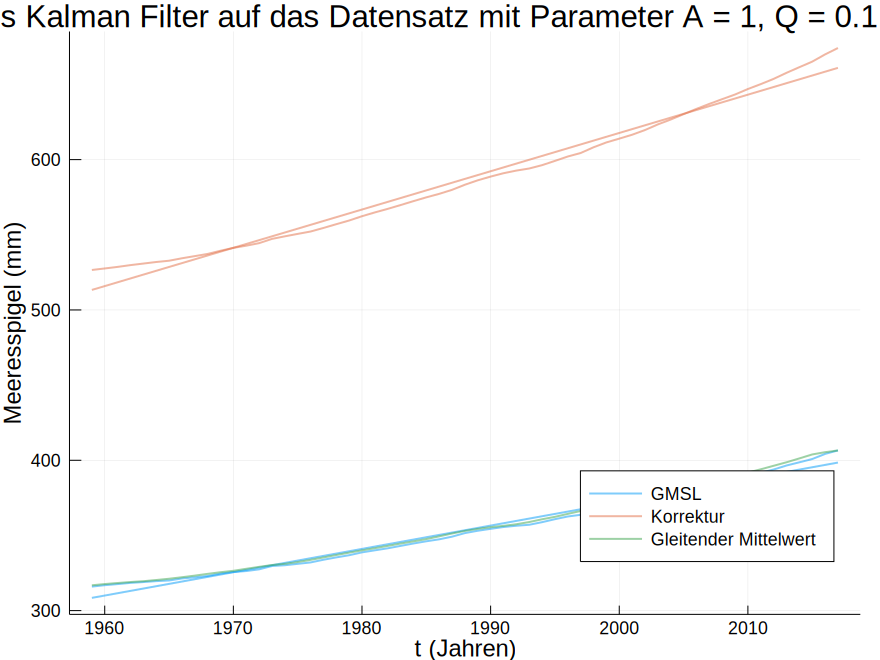

In [45]:
experiment(1, 0.1, 0.6, 0.05)

In [18]:
fit(LinearModel, @formula(Time ~ Fusioned), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Time ~ 1 + Fusioned

Coefficients:
             Estimate  Std.Error t value Pr(>|t|)
(Intercept)   1988.46   0.236534 8406.66   <1e-99
Fusioned     0.380133 0.00157461 241.414   <1e-99


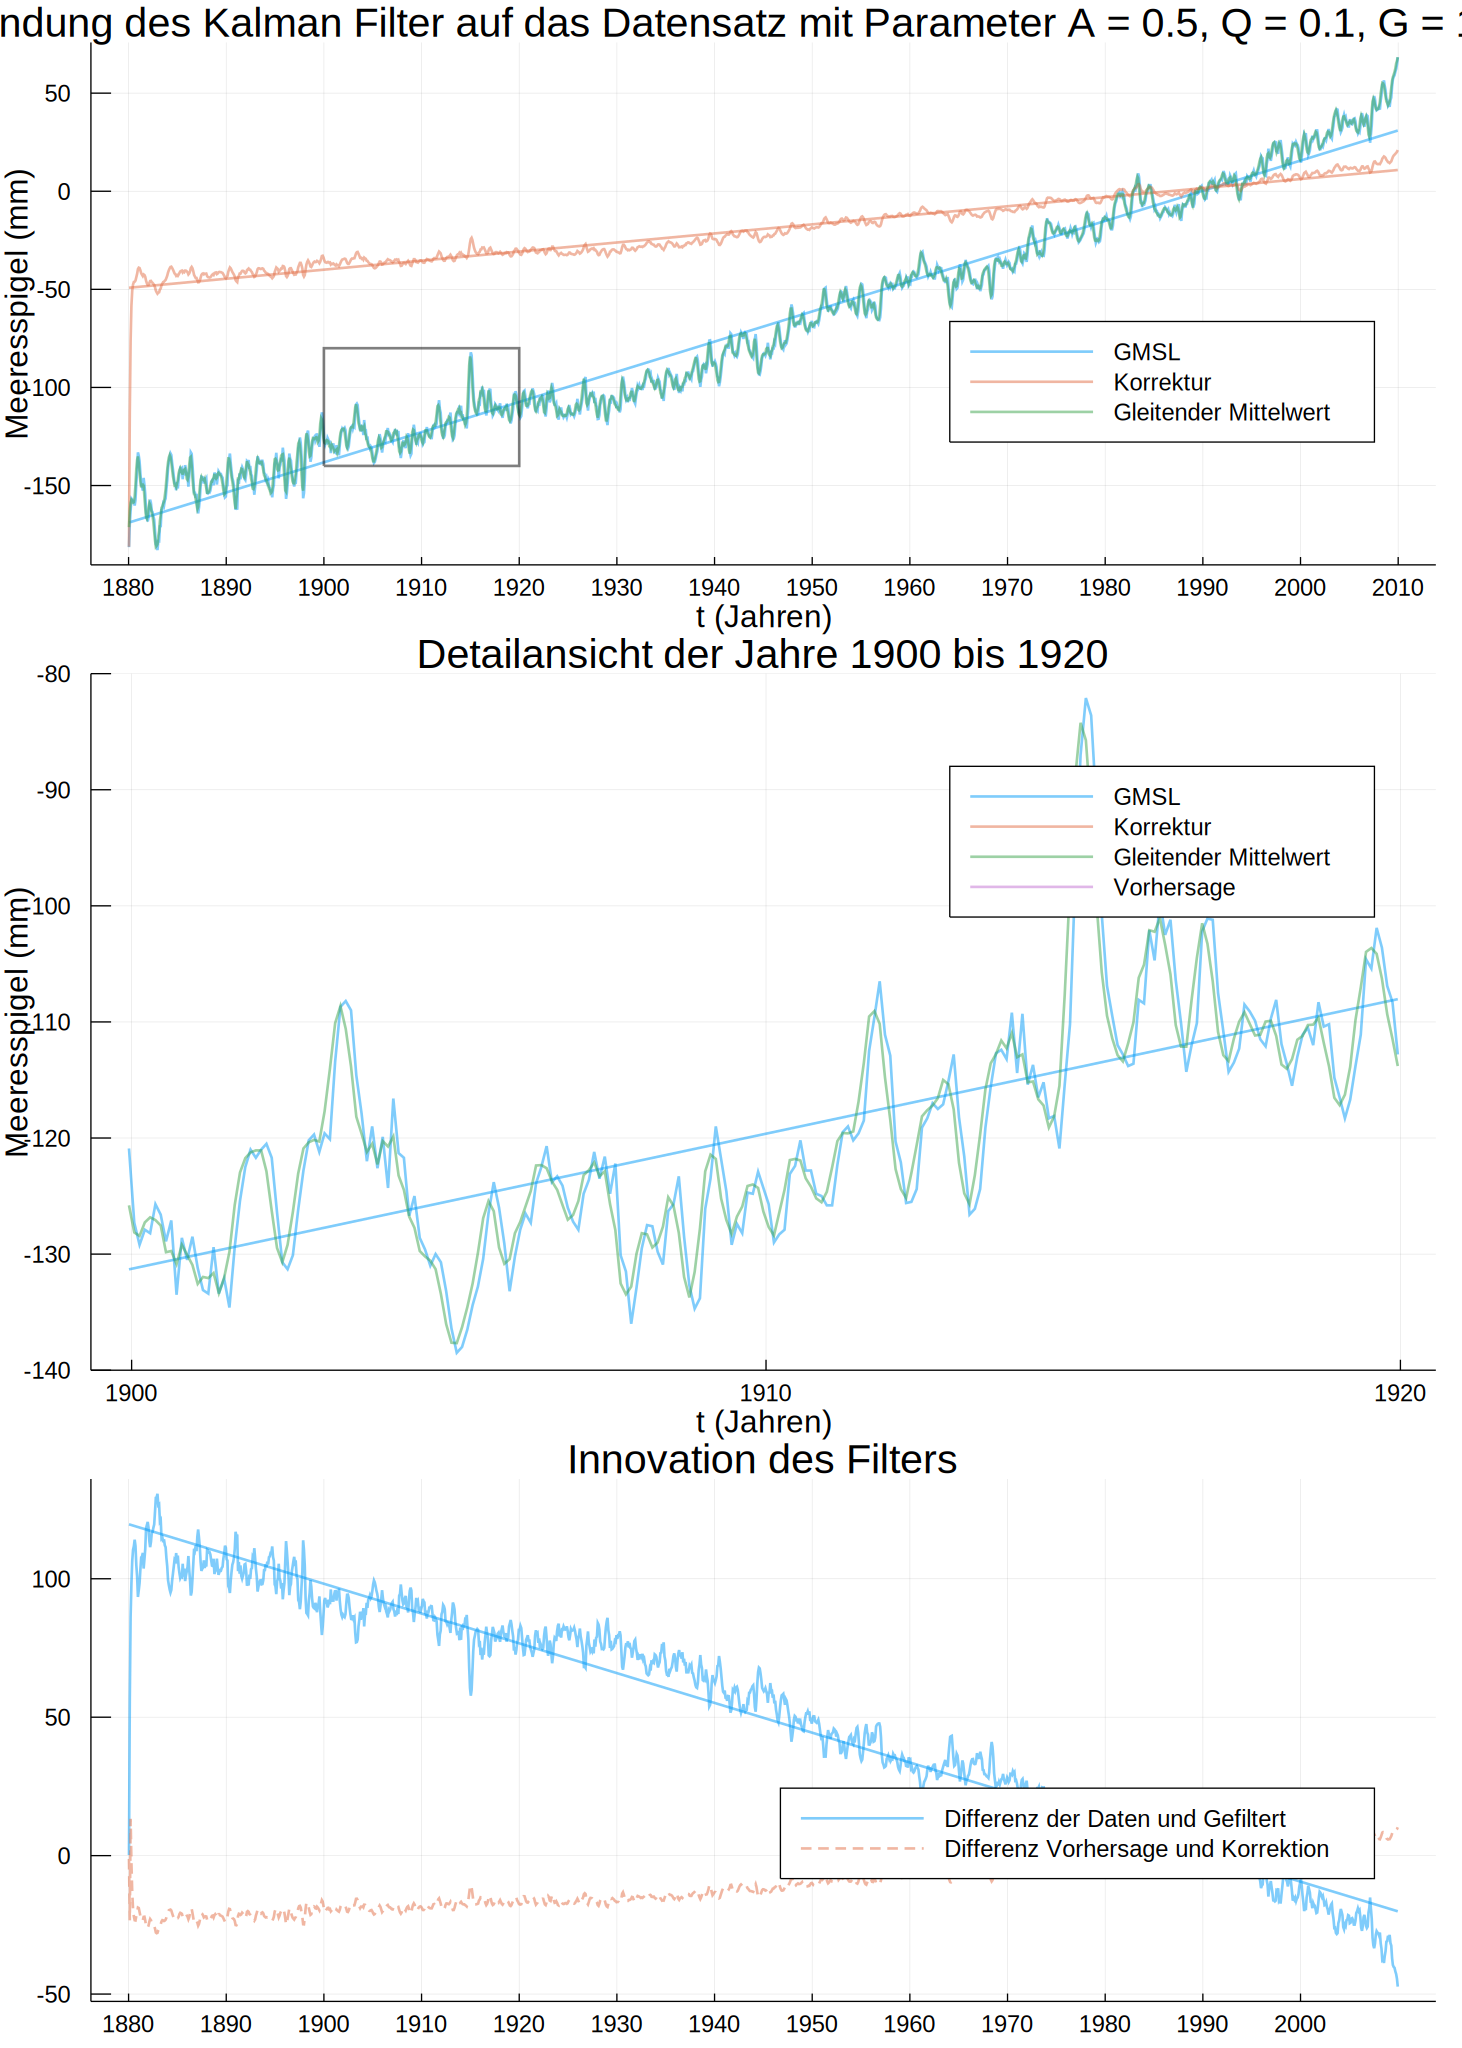

In [19]:
experiment(0.5, 0.1, 1, 0.6)

In [20]:
fit(LinearModel, @formula(Time ~ Fusioned), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Time ~ 1 + Fusioned

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   1983.66  0.364912 5435.99   <1e-99
Fusioned       2.0158 0.0138874 145.153   <1e-99


In [21]:
write_tex(table(results[1:3]...), "experiment-ergebnisse")

531